In [35]:
# importing libaries
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as math
import datetime as time

In [36]:
#read data 
data = pd.read_csv('Almeria_Airp_-hour.dat',delimiter='\t')
data = data[1:].astype(float)
data.Ta +=273.15 #convert to Kelvin
data['date_time'] = pd.to_datetime({'year':2022,'month':data.m,'day':data.dofm,'hour':data.hi})
count = (data['FF'] == 0).sum()     # how often does it occur that there is no wind 
count

np.int64(2)

In [37]:
#Testing if a new datafile works, where i also selected added the solar angle in the datasheet 
data2 = pd.read_csv('Almeria_Airp_-hour2.dat')
data2 = data2[1:].astype(float)
data.date_time

1      2022-01-01 01:00:00
2      2022-01-01 02:00:00
3      2022-01-01 03:00:00
4      2022-01-01 04:00:00
5      2022-01-01 05:00:00
               ...        
8756   2022-12-31 20:00:00
8757   2022-12-31 21:00:00
8758   2022-12-31 22:00:00
8759   2022-12-31 23:00:00
8760   2023-01-01 00:00:00
Name: date_time, Length: 8760, dtype: datetime64[ns]

In [38]:
''' What data do i have and what does it mean
    dofm: day of month
    dofy: day of the year
    hi: hour of the day
    Ta: temperature of air
    G_Gh: 
    Td: dew point temperature
    RH: relative himidity (%)
    G_DH: 
    FF: wind speed (m/s)
    DD: wind direction
    Lin: longwave radiation from the atmosphere
    RR: preciptation
    Sd: effective sunshine duration
    N: cloud cover
    hs: solar altitude
    TL: 
    G_Bn: 
    G_Gc: 
    GEX: Extraterrestrial radiation
    G_Ghmod: 
    PAR: Photosynthetically active radiation
    Snd: 
    Lup: Longwave (thermal, infrared) radiation on horizontal surface emitted from the earth's surface (longwave 
        outgoing) wavelength > 3 µm
'''
data.describe()


,m,dofm,dofy,hi,Ta,G_Gh,Td,RH,G_Dh,FF,...,TL,G_Bn,G_Gc,G_Dc,Gex,G_Ghmod,PAR,Snd,Lup,date_time
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760
mean,6.526027,15.720548,183.000000,12.500000,291.770297,208.565068,11.686050,65.532226,75.487215,3.919840,...,3.967836,226.025799,239.665068,56.261416,341.061884,208.115342,90.024087,0.0,414.843950,2022-07-02 12:30:00
min,1.000000,1.000000,1.000000,1.000000,278.050000,0.000000,-1.800000,32.400000,0.000000,0.000000,...,1.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,325.000000,2022-01-01 01:00:00
25%,4.000000,8.000000,92.000000,6.750000,287.150000,0.000000,7.500000,54.500000,0.000000,2.100000,...,3.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,380.000000,2022-04-02 06:45:00
50%,7.000000,16.000000,183.000000,12.500000,291.350000,3.000000,11.500000,65.300000,3.000000,3.500000,...,3.860000,0.000000,18.000000,11.000000,18.700000,13.850000,2.000000,0.0,410.000000,2022-07-02 12:30:00
75%,10.000000,23.000000,274.000000,18.250000,296.150000,406.000000,15.900000,75.900000,130.000000,5.300000,...,4.760000,505.000000,485.000000,107.000000,698.225000,402.375000,175.000000,0.0,442.000000,2022-10-01 18:15:00
max,12.000000,31.000000,365.000000,24.000000,311.150000,1021.000000,27.500000,100.000000,477.000000,15.100000,...,7.280000,1027.000000,1028.000000,302.000000,1282.400000,995.200000,435.000000,0.0,588.000000,2023-01-01 00:00:00
std,3.448048,8.796749,105.372043,6.922582,5.994397,282.384777,5.207643,13.688653,103.250245,2.390256,...,1.144549,294.969461,311.378666,69.079274,426.445350,278.672397,121.624157,0.0,45.025139,NaN


In [39]:
# Defining all the constants needed for the calculation
sigma = 5.670374419*10**-8          # boltzman constant 
tau_reactor = 0.92                  # transmittance according to manufacturer taken when not filled with water
epsilon_reactor = 0.97              # emsivity of water
glass_thickness = 2.2*10**-3 
R_reactor = (65*(10**-3)-2*glass_thickness)/2           # according to manufacurer
L = 1                               # an arbitraty length of a meter of reactor is used
rho_reactor = 997                            # desity of water
cp_reactor = 4186                          # soortelijke warmte water volgens wikipedia J/(Kg*K)
V_reactor = L*math.pi*R_reactor**2      # reactor volume in m^3 
epsilon_air = 1                     # value used in paper mechanistic modeling 
T_in = 273.15+13
aeration_rate = 1*V_reactor/3600       #arbitrary aeration rate in volume/time unit  
R = 8.314                                        # ideal gas constant
A = 8.07131                                      # constant for antoines law found on the wikipedia page 
B = 1730.63                                      # constant for antoines law found on the wikipedia page 
C  = 233.426 - 273.15                            # constant for antoines law found on the wikipedia page                       
heat_vap = 40.66*1000                                # heat of vaporization according to table on wikipedia (J/mol)
albedo = 0.3                            # according to wikipedia for grassland
A_cross = 2*R_reactor*L                 # Area cross section
flow_speed_reactor = 1                  # vary 0.1-1 m/s
g = 9.81                    # gravity constant 
a_a = 23.07*10**-6                      # air diffusifiy
v_a =  1.48*10**-5                     #air kinematic viscosity 
lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
Pr = 0.7                        #given in paper for a value at 25 C
 # forced convection
mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
rho_air = 1.204                     #kg/m3
lambda_glass = 1.2                  # termal resistance glass (W/(m*K)) according to brochure 
V_reactor
k_reactor = 0.598                       # thermal conductivity water (W/(mK))
k_air = lambda_a
mu_a = v_a 
rho_a = 1.293
cp_air = 1000.5                     # specific heat air (J/kg/K)
saved_fluxes = []
T_air_in = 273.15+40                # made up number, higher because of pressure added by pump putting the air into the system
tube_orientation = 90               # position of the tube with respect to the position of the sun in degrees 
tube_tilt = 0                       # tilt of the tube with respect to the ground
flow_rate = 1                       # arbitrary value (m/s) 
D_reactor = 2*R_reactor             # reactor diameter
s_reactor = 10 #2*D_reactor             # distance between centers of two neigouring cylinders
zeta = 1.96                         # friction factor of straight tube of 5.5 m according to LGEM   
V_reactor*rho_reactor*cp_reactor/3600

3.3436977368508733

In [40]:
# Setting the time array to select which points will be calculated. The time array is still in seconds
time_int = 3600
t_span = np.array((data.dofy*24+data.hi-24)*time_int)
t_start = 24*6*30+5*24
t_span = t_span[t_start:t_start+240]
t0 = [0]
y0 = [data.Ta[t_start]]
#y0 = [273.15+13]
p = [1, 1]
Temp_cap_low = True                     # True if we want to set a value that can not be exceeded
Temp_cap_high = True
T_cap = 35+273.15
T_cap_low = 20+273.15
dilution_rate =  0#V_reactor*0.25/3600                 # random suggestion
harvest_hours = [14,15]                       # the hours when broth can be harvested
len(t_span)

240

In [41]:
# Returns the amount of sunlight that is reflected back basaed on the incoming angle. This is based on fresnels law
def fresnel(theta_1):
    n_air = 1                    #refractive index of air according to wikipedia
    n_glass =  1.473                 #refractive index of glass according to manufacturer
    theta_2 = math.asin(n_air/n_glass*math.sin(theta_1))                # from snells law
    if n_air * np.sin(theta_1)>n_glass:
        return 1 
    R_s = ((n_air*math.cos(theta_1)-n_glass*math.cos(theta_2))/(n_air*math.cos(theta_1)+n_glass*math.cos(theta_2)))**2 
    R_p = ((n_air*math.cos(theta_2)-n_glass*math.cos(theta_1))/(n_air*math.cos(theta_2)+n_glass*math.cos(theta_1)))**2
    R_tot = (R_s+R_p)/2
    return R_tot
def average_reflection(theta_1):            # takes into account lamberts cosine law
    ref = fresnel(theta_1)*math.cos(theta_1)
    return ref
fresnel(0*math.pi)
def sumfunc(x):
    return x
ref_test,error1 = integrate.quad(average_reflection,0,math.pi*0.5)
sum_test, error2 = integrate.quad(sumfunc,0,math.pi)
ref_test/sum_test
average_reflection(0)
1- ref_test

0.9357742149803852

In [42]:
def added_heat(t,y,time_index,total_flux):
    if Temp_cap_low:
        if y<T_cap_low and total_flux<0:
            Q = -total_flux
        elif (y+total_flux*3600/(cp_reactor*rho_reactor*V_reactor))<T_cap_low and total_flux<0:
            Q = -total_flux
        else:
            Q  = 0
        return Q
    else:
        Q=0
    return Q
added_heat(1,273.15+8,15,-3.5) 

3.5

In [43]:
def removed_heat(t,y,time_index,total_flux):                # if the temperature exceeds the maximum and Temp_cap is true, the amount of extra heat gained is removed 
    if Temp_cap_high:
        if y >T_cap and total_flux>0:
            #Q = (T_cap-y)*cp_reactor*rho_reactor*V_reactor/3600-total_flux
            Q = -total_flux
        elif (y+total_flux*7200/(cp_reactor*rho_reactor*V_reactor))>T_cap and total_flux>0:
            Q = -total_flux
        else:
            Q = 0
        return Q
    else:
        Q = 0
    return Q
check = 3.5*3600/(cp_reactor*rho_reactor*V_reactor)
removed_heat(1,273.15+40,15,3.5)


-3.5

In [44]:
# Try to estimate the amount of radiation from on reactor onto the next reactor 
# Still under construction
def reactor_to_reactor(t,y,time_index):
    R = 1
    S = ((s_reactor-(2*R_reactor))/R_reactor)
    C = 1+R+S
    Fij = 1/(2*math.pi)*(math.pi+(C**2-(R+1)**2)**0.5-(C**2-(R-1)**2)**0.5+(R-1)*math.acos((R/C)-(1/C))-(R+1)*math.acos((R/C)+(1/C)))
    return Fij
F_between_reactor = reactor_to_reactor(1,292,15)
F_between_reactor

0.0009644819067668607

In [45]:
# Try to estimate the amount of radiation from the ground coming onto the reactor 
# Still under construction
def ground_to_reactors(t,y,time_index):                     # according to table 13.1 
    Fij= 1-(1-(D_reactor/s_reactor)**2)**0.5+D_reactor/s_reactor*math.atan(((s_reactor**2-D_reactor**2)/(D_reactor**2))**0.5)
    return Fij
ground_to_reactors(1,292,15)

0.009500663884183852

In [46]:
# Returns the ground reflected radiation, existing of parts of the direct and diffuse solar radiation and the atmoshperic radiation
def ground_reflected_rad(t,y,time_index):
    Q = albedo*(data.G_Dh[time_index]+data.Lin[time_index]+data.G_Gh[time_index])*2*R_reactor*L*tau_reactor*epsilon_reactor
    return Q
ground_reflected_rad(1,300,15)

np.float64(13.70913804)

In [47]:
# returns the energy flux responsible for the evaporation of water in the reactor, based on the relative humidity, air temperature and reactor temperature
def Q_evap(t,y,time_index):             #perfect equilibrium of water and air is reached at the outlet
    vap_pres_in = 10**(A-(B/(C+data.Ta[time_index])))       #antoines law
    moles_in = vap_pres_in*aeration_rate*(data.RH[time_index]/100)/(R*data.Ta[time_index])
    vap_pres_out = 10**(A-(B/(C+y)))
    moles_out = vap_pres_out*aeration_rate/(R*y) 
    Q = (moles_out-moles_in)* heat_vap
    return -Q
Q_evap(1,300,15)

np.float64(-0.00024634029551321254)

In [48]:
# return the heat going into the system with the set flowrate and initial temperature 
def flow_medium_in(t,y,time_index):
    #if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
    if  data.date_time[time_index].hour in harvest_hours:
        Q = dilution_rate*T_in*rho_reactor*cp_reactor     # Since the dilution rate is expressed as percentage of volume, no volume included here
    else:
        Q = 0
    return Q
flow_medium_in(1,273,15)
    

0.0

In [49]:
# Returns the heat coming out of the system with the set flowrate and system temperature
def flow_harvest_out(t,y,time_index):
    #if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
    if  data.date_time[time_index].hour in harvest_hours:
        Q = dilution_rate*y*rho_reactor*cp_reactor     # Since the dilution rate is expressed as percentage of volume, no volume included here
    else:
        Q = 0
    return -Q
flow_harvest_out(1,300,15)

0

In [50]:
# Returns the amount of heat coming into the system based on measured ground radiation 
def ground_infrared_radiation(t,y,time_index):      #assume the Lup value is indeed the emmited ground radiation
    Q = tau_reactor*epsilon_reactor*data.Lup[time_index]*2*R_reactor*L              # Area is cross section
    #Q = tau_reactor*epsilon_reactor*data.Lup[time_index]*2*R_reactor*L             # can be adapted so that the area can include view factor
    return Q
ground_infrared_radiation(1,273,1)

np.float64(20.65834608)

In [51]:
# Returns the amount of radiation going out of the system, based on the black body radiation from the reactor 
def reactor_infrared_radiation(t,y,time_index):
    Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*2)                                            # consider cross section, radiation going both up and down
    #Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*math.pi)                                     # consider full area around the tube 
    #Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*math.pi)*(1-2*F_between_reactor)               # consider view factor to two neighbouring cylinders
    return -Q
reactor_infrared_radiation(1,273,1)
    

-34.06626388425834

In [52]:
# Returns the measured diffuse solar radiation based on measured data and a cross section as surface area
def diffuse_solar_rad(t,y,time_index):
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Dh[time_index]
    return Q
diffuse_solar_rad(1,300,15)

np.float64(8.9231076)

In [53]:
# Returns the measured direct solar radiation based on measured data and a cross section area as surface 
def direct_solar_rad(t,y,time_index): #in the paper they do something with a formfactor here, check later why
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Gh[time_index]
    return Q
direct_solar_rad(1,273,15)

np.float64(19.7389956)

In [54]:
# Returns the infrared radiation based on measured data and a cross section as surface area. I made a comparison of 3 ways to calculate this, hence 3 functions. 
# The first function is used in the heat model 
def infrared_rad_air(t,y,time_index):
        #Q = tau_reactor*epsilon_reactor*epsilon_air*2*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        Q = data.Lin[time_index]*R_reactor*2*L*tau_reactor*epsilon_reactor
        return Q
def infrared_rad_air2(t,y,time_index):
        Q = tau_reactor*epsilon_reactor*epsilon_air*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        return Q
def infrared_rad_air_rocca(t,y,time_index):
        Cc = data.N[time_index] #cloud coverage 
        Em = 0.937*(10**-5)* (data.Ta[time_index]**2)*(1+0.17*(Cc/8)**2)                # cloud cover divided by 8 because of the scale (octa) used 
        lambda_heat = 0.7
        Q = sigma*(data.Ta[time_index]**4)*math.sqrt(lambda_heat*Em)*epsilon_air*tau_reactor*R_reactor*2*L
        return Q

infrared_rad_air(1,27,1)

np.float64(17.3054208)

In [55]:
# function linking the heat generated by the pump to the pressure drop
# still under construction, not implemented yet
def pump_force(t,y,time_index):     
    press_loss  = zeta*rho_reactor/(2*5.5)*flow_rate**2
    Q = press_loss*V_reactor*flow_rate/L
    return Q
pump_force(1,27,1)
flow_rate

1

In [56]:
# Returns forced convection based on relation with wind speed. 
# Assumes cross flow, relation is based on found equation in Fundamentals of Heat and mass transfer(book)
# Has to be cleaned up a bit more 
def convection(t,y,time_index):
    #new constants 
    g = 9.81                    # gravity constant 
    a_a = 23.07*10**-6                      # air diffusifiy
    v_a =  1.48*10**-5                     #air kinematic viscosity 
    k_reactor = 0.598                       # thermal conductivity water (W/(mK))
    lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
    Pr = 0.7                        #given in paper for a value at 25 C
    k_air = lambda_a
    # forced convection
    mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
    mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
    rho_air = 1.204                     #kg/m3
    mu_a = v_a 
    rho_a = 1.293
    cp_air = 1000.5                     # specific heat air (J/kg/K)

    # Calculating dimensionless numbers
    Re_reactor = rho_reactor*flow_speed_reactor*(2*R_reactor)/mu_reactor
    #Pr_reactor = 50000/((y-273.15)**2+155*(y-273.15)+3700)          # according to wikipedia
    Re_air = rho_air*data.FF[time_index]*2*(R_reactor+glass_thickness)/mu_air           # formula according to wikipedia 
    #Pr_air = 10**9/(1.1*(data.Ta[time_index]-273.15)**3-1200*(data.Ta[time_index]-273.15)**2+322000*(data.Ta[time_index]-273.15)+1.393*10**9) # formula according to wikipedia
    #Ra = (g*abs(y-data.Ta[time_index])*L**3)/(a_a*v_a*data.Ta[time_index])
    #Re = rho_a*2*R_reactor*data.FF[time_index]/mu_a
    #h_forced = lambda_a/(2*R_reactor)*(0.3+0.62*(Re**0.5)*(Pr**(1/3))/(1+(0.4/Pr)**(2/3))**0.25)*(1+(Re/282000)**(5/8))**0.8
    
    #old calculation
    #h_co = lambda_a/L*(0.825+(0.387*Ra**(1/6))/((1+(0.492/Pr)**(9/16))**8/27))**2
    #Q = h_forced*(data.Ta[time_index]-y)*math.pi*R_reactor*L
    Pr_air = cp_air*mu_air/k_air
    Pr_reactor = cp_reactor*mu_reactor/k_reactor



    #Dont forget the case where there is no wind and therefore natural convection only occurs
    if Re_air<= 4000:                   # according to tabel 7.2 in book 'fundamentals of heat and mass transfer'
        C = 0.683
        m = 0.385
    elif Re_air<=40000:
        C = 0.193
        m = 0.618
    elif Re_air<=4000000:
        C = 0.027
        m = 0.805
    else:
        return 0
    Nu_air = C*(Re_air**m)*(Pr_air**(1/3))
    Nu_inside = 0.027*(Re_reactor**0.8)*(Pr_reactor**0.33)*(L+0.7*((2*R_reactor))/L)   # for Re>2000 accroding to reader transfer processes
    R_inside = 1/(Nu_inside*k_reactor*math.pi*L)                       
    R_glass = math.log((R_reactor+glass_thickness)/R_reactor)/(2*math.pi*L*lambda_glass)    # according to tabel 7.2 in book 'fundamentals of heat and mass transfer' 3.26
    R_outside = 1/(Nu_air*k_air*math.pi*L)
    #Ra = g*beta*()
    #Nu_air_free = C_free*Ra^n                                               # formula 9.33 in the bible
    
    if data.FF[time_index]==0:
        R_outside = 0.001
        return 0
        #R_outside = 1/(Nu_air_free*k_air*math.pi*L)
    else:
        R_outside = 1/(Nu_air*k_air*math.pi*L)
    Rtot = R_inside+R_glass+R_outside
    Q = (data.Ta[time_index]-y)/Rtot
    #Q = data.Ta[time_index]-y
    return Q
convection(1,292,15)    

np.float64(-0.9118654421396749)

In [57]:
# Returns the amount of energy required to get the aeration air to the reactor temperature
def aeration(t,y,time_index):           #the assumption is that all the air takes the temperature of the reactor
    Q = aeration_rate*(T_air_in-y)*cp_air*rho_air
    return Q
aeration(1,292,15)    

0.020412047981619864

In [58]:
# Adds up all the calculated fluxes and returns the sum as input for the integration algorithm
def heat_bal(t,y,p):
    '''creating the measured values at time t as input'''
    time_index = (t//3600)                    # the algorithm loop over this heat balance more often than just for every step, therefore the // to indix to the right value
    rest = (time_index%3600)/3600
    u = data.Ta[time_index]
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_medium_added  = flow_medium_in(t,y,time_index)
    Q_broth_out = flow_harvest_out(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    Q_aeration = aeration(t,y,time_index)
    Q_pump = pump_force(t,y,time_index)
    saved_fluxes.append([time_index])
    '''To be implemented: pump, aeration  '''
    dxdt = (Q_direct_solar_rad+Q_diffuse_solar_rad+Q_ground_radiation+Q_medium_added+Q_air_infrared+Q_ground_reflected+Q_react_infrared+Q_broth_out+Q_evaporation+Q_convection+Q_aeration+Q_pump)/(rho_reactor*cp_reactor*V_reactor)
    max_capped_heat = removed_heat(t,y,time_index,dxdt)
    min_capped_heat = added_heat(t,y,time_index,dxdt)
    return (max_capped_heat+min_capped_heat+dxdt)
heat_bal(7200,10,1)

np.float64(0.0)

In [59]:
# Made the heat balances suited for interpolated time data
def heat_bal2(t,y,p):
    '''creating the measured values at time t as input'''
    time_index = (t//3600)                    # the algorithm loop over this heat balance more often than just for every step, therefore the // to indix to the right value
    rest = (time_index%3600)/3600
    u = data.Ta[time_index]
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)*(1-rest)+reactor_infrared_radiation(t,y,time_index+1)*rest
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)*(1-rest)+direct_solar_rad(t,y,time_index+1)*rest
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)*(1-rest)+diffuse_solar_rad(t,y,time_index+1)*rest
    Q_air_infrared = infrared_rad_air(t,y,time_index)*(1-rest)+infrared_rad_air(t,y,time_index+1)*rest
    Q_medium_added  = flow_medium_in(t,y,time_index)*(1-rest)+flow_medium_in(t,y,time_index+1)*rest
    Q_broth_out = flow_harvest_out(t,y,time_index)*(1-rest)+flow_harvest_out(t,y,time_index+1)*rest
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)*(1-rest)+ground_infrared_radiation(t,y,time_index+1)*rest
    Q_evaporation = Q_evap(t,y,time_index)*(1-rest)+Q_evap(t,y,time_index+1)*rest
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)*(1-rest)+ground_reflected_rad(t,y,time_index+1)*rest
    Q_convection =  convection(t,y,time_index)*(1-rest)+convection(t,y,time_index+1)*rest
    Q_aeration = aeration(t,y,time_index)*(1-rest)+aeration(t,y,time_index+1)*rest
    Q_pump = pump_force(t,y,time_index)
    saved_fluxes.append([time_index])
    '''To be implemented: pump, aeration  '''
    dxdt = (Q_direct_solar_rad+Q_diffuse_solar_rad+Q_ground_radiation+Q_medium_added+Q_air_infrared+Q_ground_reflected+Q_react_infrared+Q_broth_out+Q_evaporation+Q_convection+Q_aeration+Q_pump)/(rho_reactor*cp_reactor*V_reactor)
    max_capped_heat = removed_heat(t,y,time_index,dxdt)
    min_capped_heat = added_heat(t,y,time_index,dxdt)
    return (max_capped_heat+min_capped_heat+dxdt)
heat_bal(8000,300,1)-heat_bal2(8000,300,1)

np.float64(1.2015155771401623e-07)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.599e+07  1.599e+07 ...  1.684e+07  1.685e+07]
        y: [[ 2.950e+02  2.951e+02 ...  2.953e+02  2.944e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1736
     njev: 0
      nlu: 0


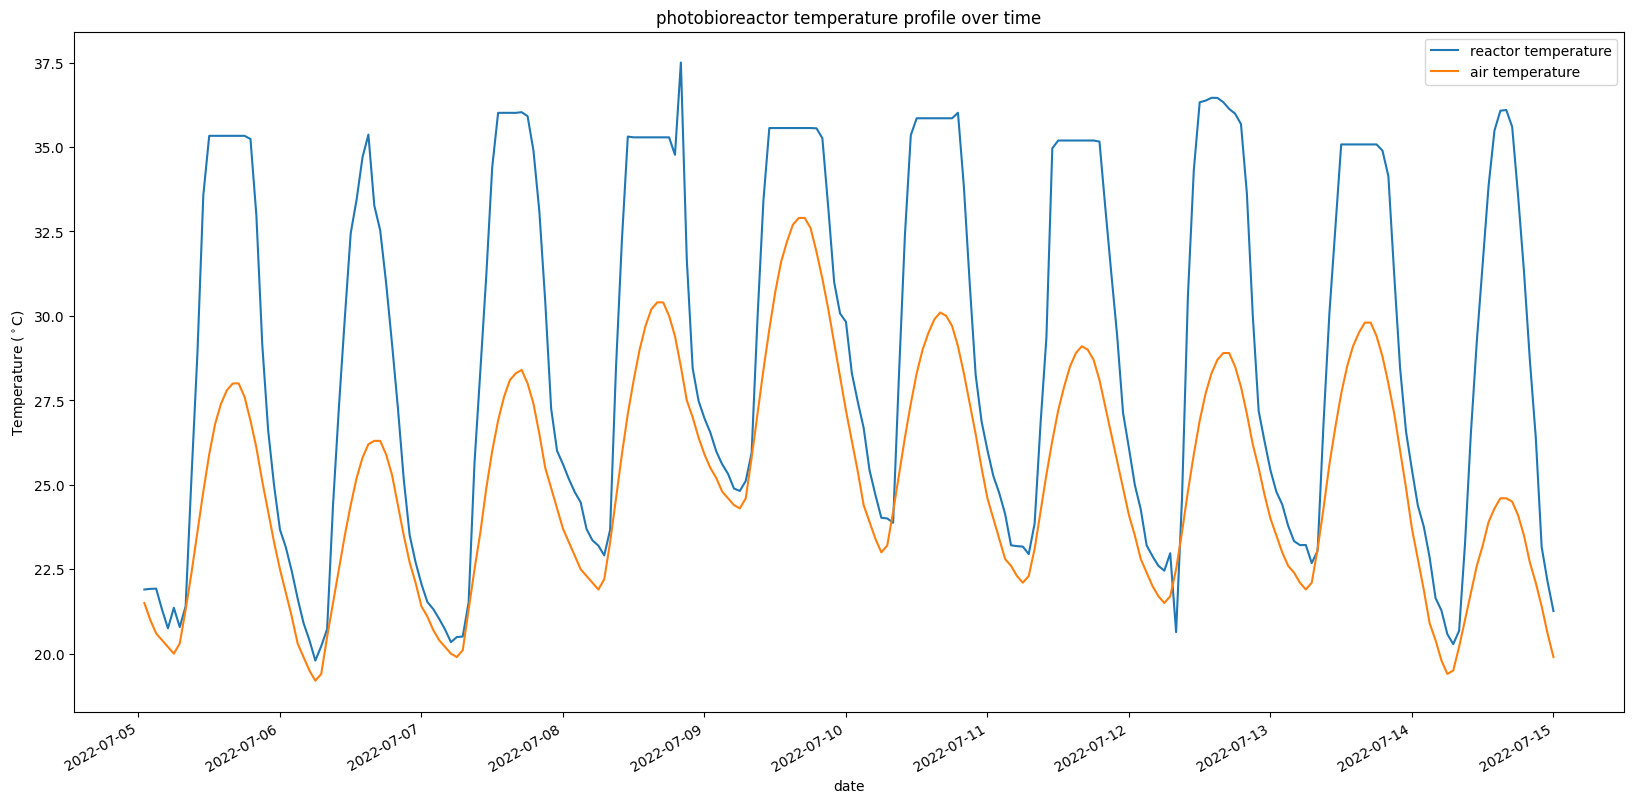

In [60]:
# From the startingpoint y0 calculate the temperature in time steps by calculating the heat balance
saved_fluxes=[] 
solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01],t_eval=t_span, method='RK45')
#solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01], method='RK45')
#solver = integrate.solve_ivp (heat_bal,[0, t_span[-1]], y0, t_eval=t_span, args = [0.0000001])
print(solver)
t_vals = solver.t
y_vals_check = solver.y
y_vals = y_vals_check[0]                #Did this to overcome the problem that the values are stored in a matrix. 
hours = t_span/(time_int*24)
air_temp = data.Ta[hours*24]
t_vals_days = 24/hours
time_values = data.date_time[t_span/time_int]


##          plot results
plt.xlabel('date')
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time')
plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15)
#plt.plot(time_values,y_vals[:-1]-273.15)
plt.gcf().autofmt_xdate()
plt.legend(['reactor temperature','air temperature'])



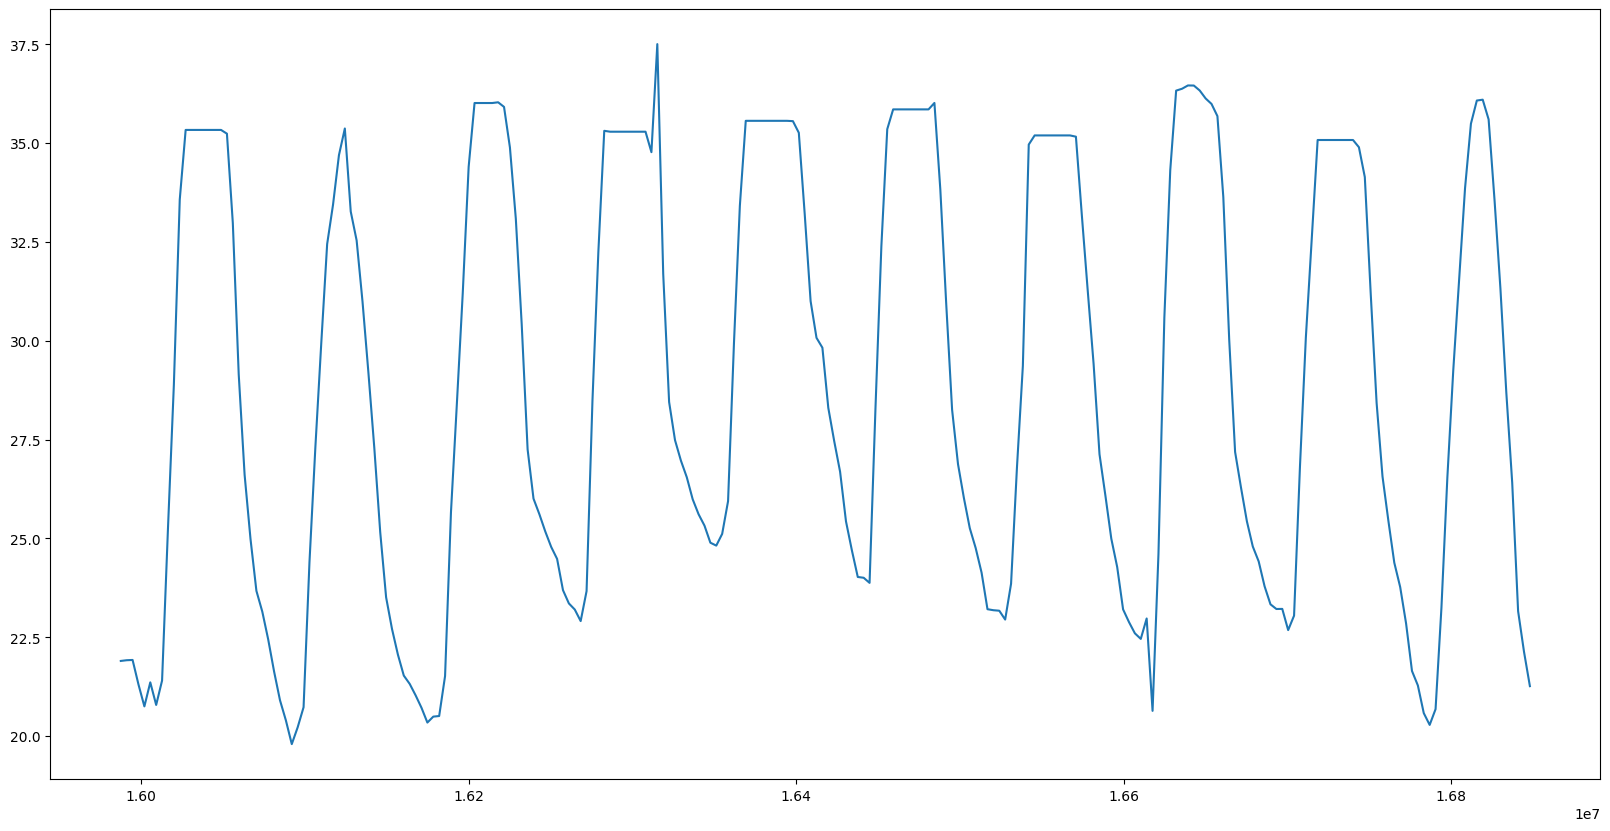

In [61]:
solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01],t_eval=t_span, method='RK45')
t_vals = solver.t
y_vals_check = solver.y[0]
plt.plot(t_vals,y_vals_check-273.15)


240

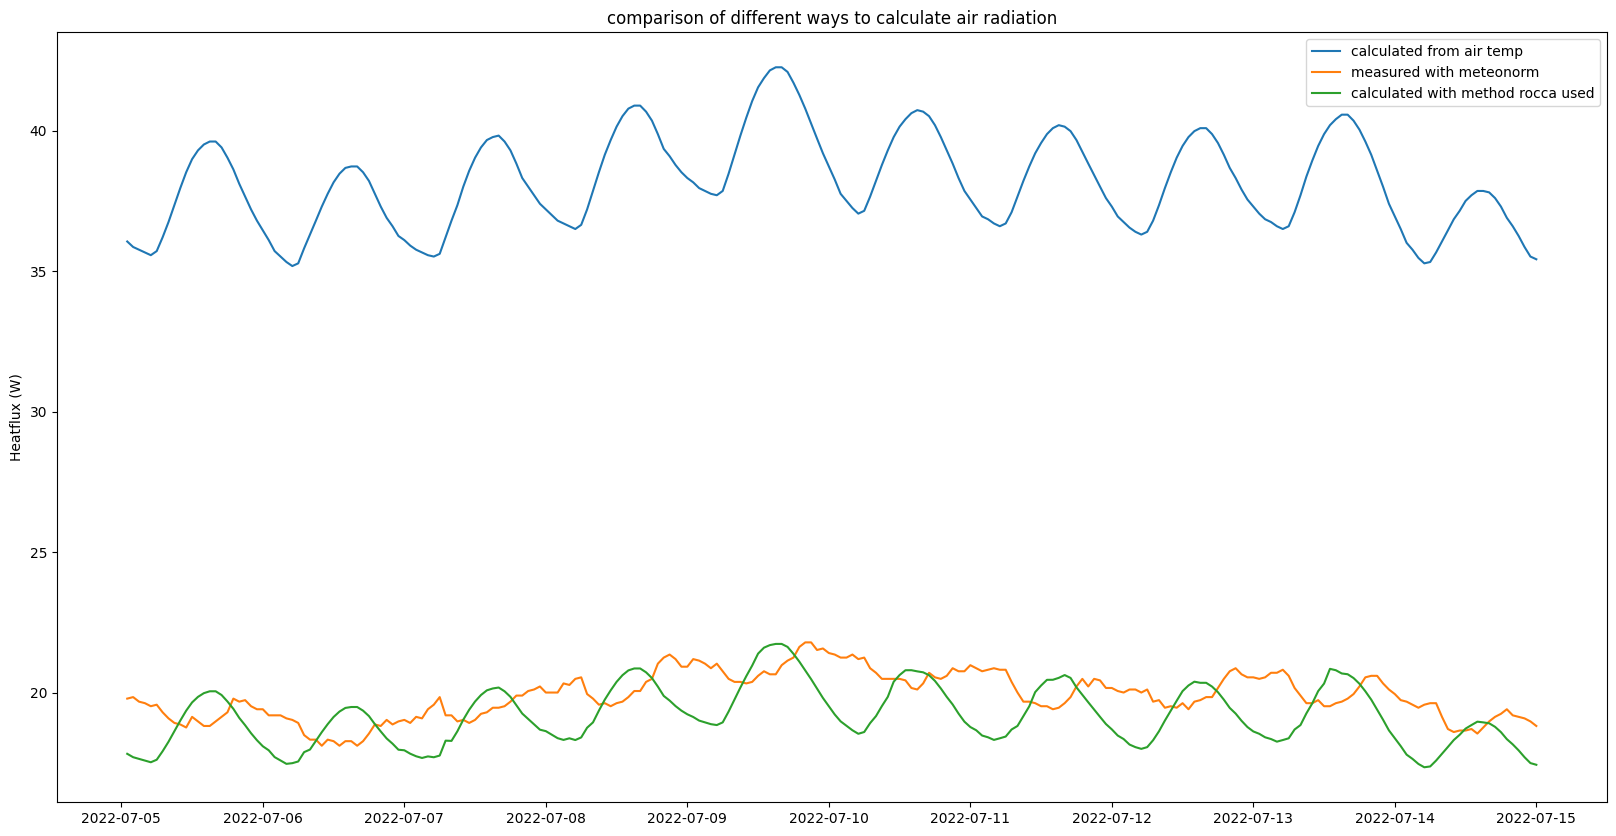

In [62]:
# comparison of the different ways to calculate the atmospheric radiation
Q_air_calc = []
Q_air_meas = []
Q_air_rocca = []
clouds = []
wind = []
ground_rad = []
convection_vals = []
direct_light = []
indirect_light = []
time_index = t_span[0]/3600
general_index = -1
for t in t_vals:
    time_index+=1
    general_index+=1
    try: 
        y = y_vals[general_index]
    except:
        pass
    try: 
        Q_air_calc.append(infrared_rad_air2(t,y,time_index))
        Q_air_meas.append(infrared_rad_air(t,y,time_index))
        Q_air_rocca.append(infrared_rad_air_rocca(t,y,time_index))
        clouds.append(data.N[time_index])
        wind.append(data.FF[time_index])
        convection_vals.append(convection(t,y,time_index))
        ground_rad.append(ground_infrared_radiation(t,y,time_index))
        direct_light.append(direct_solar_rad(t,y,time_index))
        indirect_light.append(diffuse_solar_rad(t,y,time_index))
    except:
        pass
if len(time_values)>len(Q_air_calc): #i think this only causes problem if the very last values of the year are used
    plt.plot(time_values[0:-1],Q_air_calc,time_values[0:-1],Q_air_meas,time_values[0:-1],Q_air_rocca)
else:
    plt.plot(time_values,Q_air_calc,time_values,Q_air_meas,time_values,Q_air_rocca)
plt.legend(['calculated from air temp','measured with meteonorm','calculated with method rocca used'])
plt.title('comparison of different ways to calculate air radiation' )
plt.axis.titlesize=1000
plt.ylabel('Heatflux (W)')
len(convection_vals)

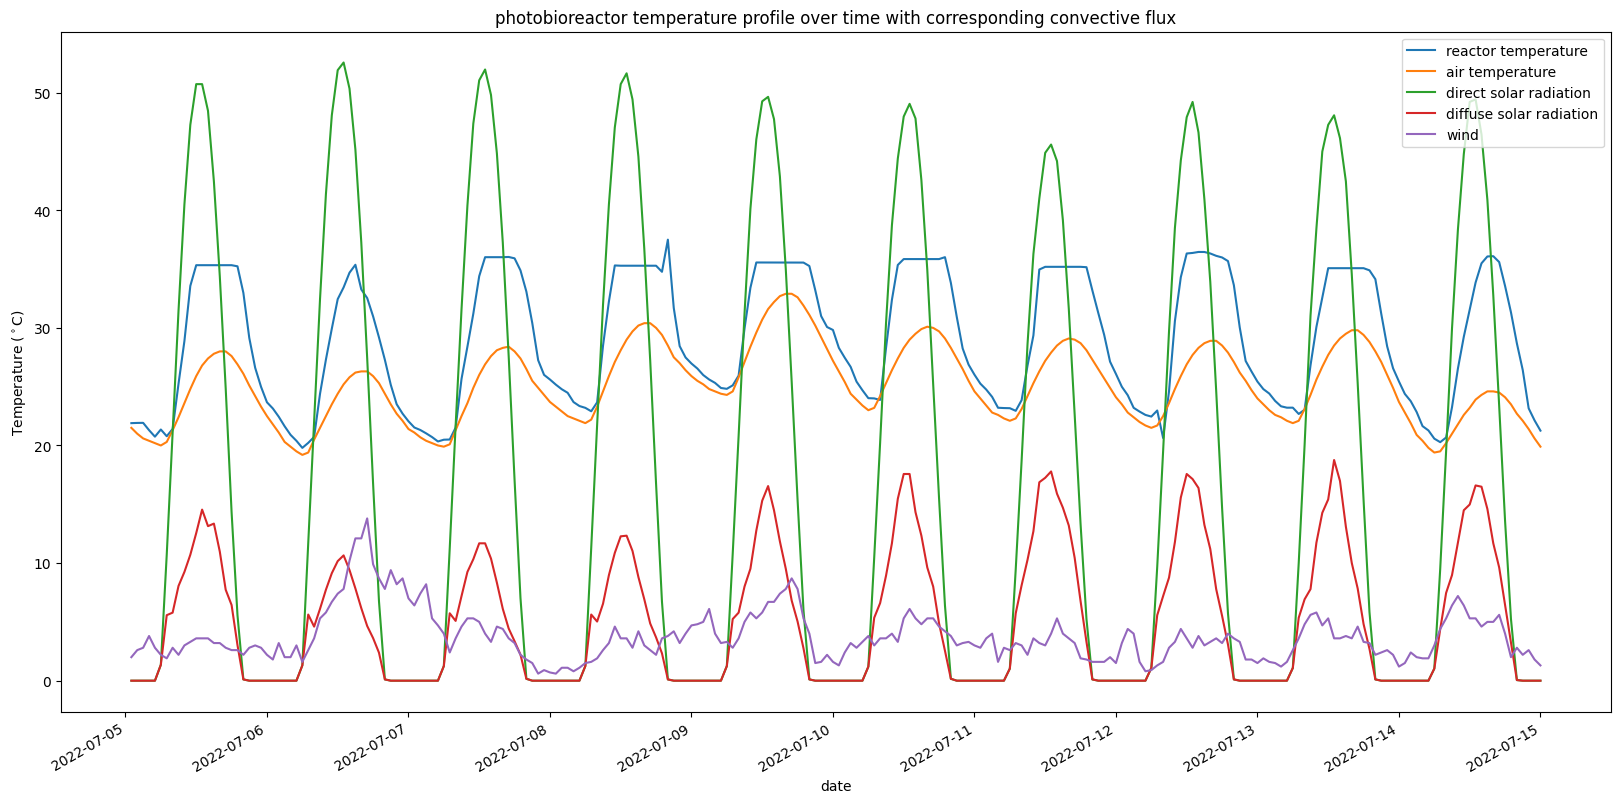

In [63]:
# Check if weird temperature values are caused by strange convection values 
difference = air_temp-y_vals
plt.xlabel('date')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time with corresponding convective flux')
if len(time_values)>len(Q_air_calc): #i think this only causes problem if the very last values of the year are used
    plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15,time_values[0:-1],wind,time_values[0:-1],convection_vals)
else:
    plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15,time_values,direct_light,time_values,indirect_light,time_values,wind)
plt.legend(['reactor temperature','air temperature','direct solar radiation','diffuse solar radiation','wind'])
plt.gcf().autofmt_xdate()

In [64]:
cooling_energy = {}
heating_energy = {}
def cooled_overview(value,index):
    date_time_value = data.date_time[index]
    date = date_time_value.date()
    if date in cooling_energy:
        cooling_energy[date]+= -value
    else:
        cooling_energy[date]= -value
def heated_overview(value,index):
    date_time_value = data.date_time[index]
    date = date_time_value.date()
    if date in heating_energy:
        heating_energy[date]+= value
    else:
        heating_energy[date]= value

array([[ 0.00000000e+00,  0.00000000e+00,  2.20103321e+01, ...,
        -7.93873667e-05, -3.34057822e+00,  1.74510016e-02],
       [ 0.00000000e+00,  0.00000000e+00,  2.20103321e+01, ...,
        -7.61735725e-05, -5.62945280e+00,  1.74446636e-02],
       [ 0.00000000e+00,  0.00000000e+00,  2.20103321e+01, ...,
        -7.53127468e-05, -4.01028825e+00,  1.80442973e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.20103321e+01, ...,
        -1.12237811e-04, -6.51749658e+00,  1.72429896e-02],
       [ 0.00000000e+00,  0.00000000e+00,  2.16317760e+01, ...,
        -9.95478734e-05, -4.65608780e+00,  1.80838635e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(240, 10))

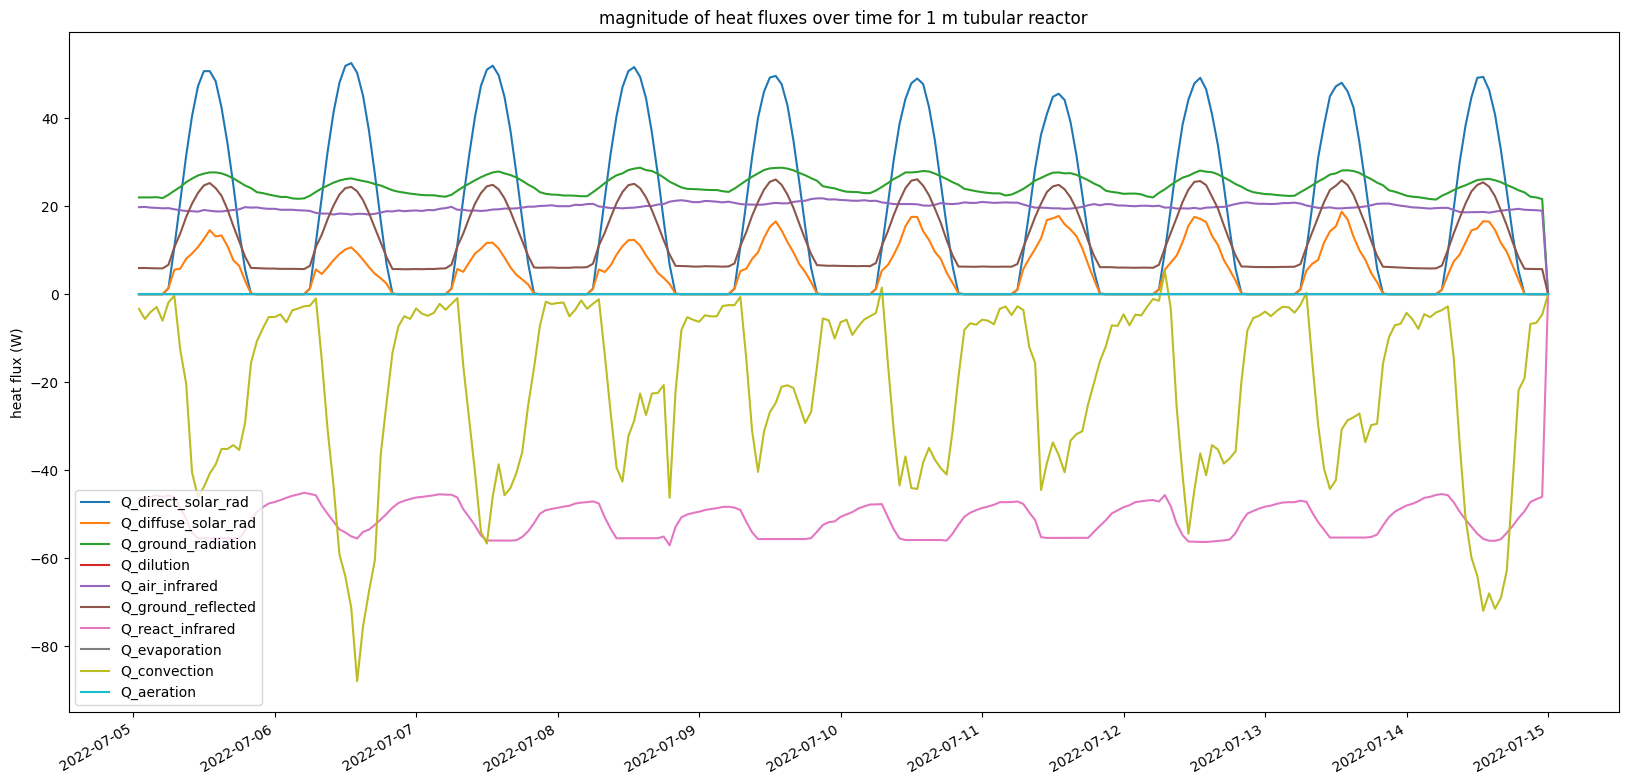

In [65]:
#reverse engineer the heat fluxes, can not extract them directly out of the heat balance function because the integration method
# integration method loops over heat balance multiple times per time step.
cooling_energy = {}
heating_energy = {}
Q_data = np.zeros((len(t_vals)+1,13))
time_index = t_span[0]/3600
general_index = 0
for t in t_vals:
    general_index += 1
    time_index+=1
    try: 
        y = y_vals[general_index]
        Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
        Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
        Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
        Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
        Q_air_infrared = infrared_rad_air(t,y,time_index)
        Q_dilution  = flow_medium_in(t,y,time_index)+flow_harvest_out(t,y,time_index)
        Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
        Q_evaporation = Q_evap(t,y,time_index)
        Q_ground_reflected = ground_reflected_rad(t,y,time_index)
        Q_convection =  convection(t,y,time_index)
        Q_aeration = aeration(t,y,time_index)
        overall = Q_react_infrared+Q_direct_solar_rad+Q_diffuse_solar_rad+Q_air_infrared+Q_dilution+Q_ground_radiation+Q_evaporation+Q_ground_reflected+Q_convection+Q_aeration
        extra_cooled = removed_heat(t,y,time_index,overall)
        extra_heated = added_heat(t,y,time_index,overall)
        cooled_overview(extra_cooled,time_index)
        heated_overview(extra_heated,time_index)
        overall = overall+extra_cooled+extra_heated
    #time_index-=1
        Q_data[general_index] = [Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_dilution,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_evaporation,Q_convection,Q_aeration,extra_cooled,extra_heated,overall]
    except:
        pass
    #time_index+=1                       #during the calculation the previous y values are inputted, and the time index is of the next hour, in this way this reverse engineering compensates for that

    
#Q_vals.append([Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_medium_added,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_broth_out,Q_evaporation])
Q_data = Q_data[1:]
#columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection','Q_aeration','extra cooled','extra heated','overall']
columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection','Q_aeration']
Q_data = Q_data[:,0:10]

Fluxes = pd.DataFrame(Q_data, index= time_values,columns=columnheader)
Fluxes.describe()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time_values,Fluxes)
plt.legend(columnheader)
plt.gcf().autofmt_xdate()
plt.title('magnitude of heat fluxes over time for 1 m tubular reactor')
plt.ylabel('heat flux (W)')
Q_data[:,0:10]

<bound method NDFrame.describe of                Cooling   Heating
Date                            
2022-07-05  293.541865  4.923558
2022-07-06   84.190943  9.255787
2022-07-07  222.322630  2.660743
2022-07-08  369.115680  0.000000
2022-07-09  409.035191  0.000000
2022-07-10  301.454155  0.000000
2022-07-11  317.369394  0.000000
2022-07-12  302.149142  0.000000
2022-07-13  338.887760  0.000000
2022-07-14   95.153379  7.178814
2022-07-15    0.000000  4.408348>

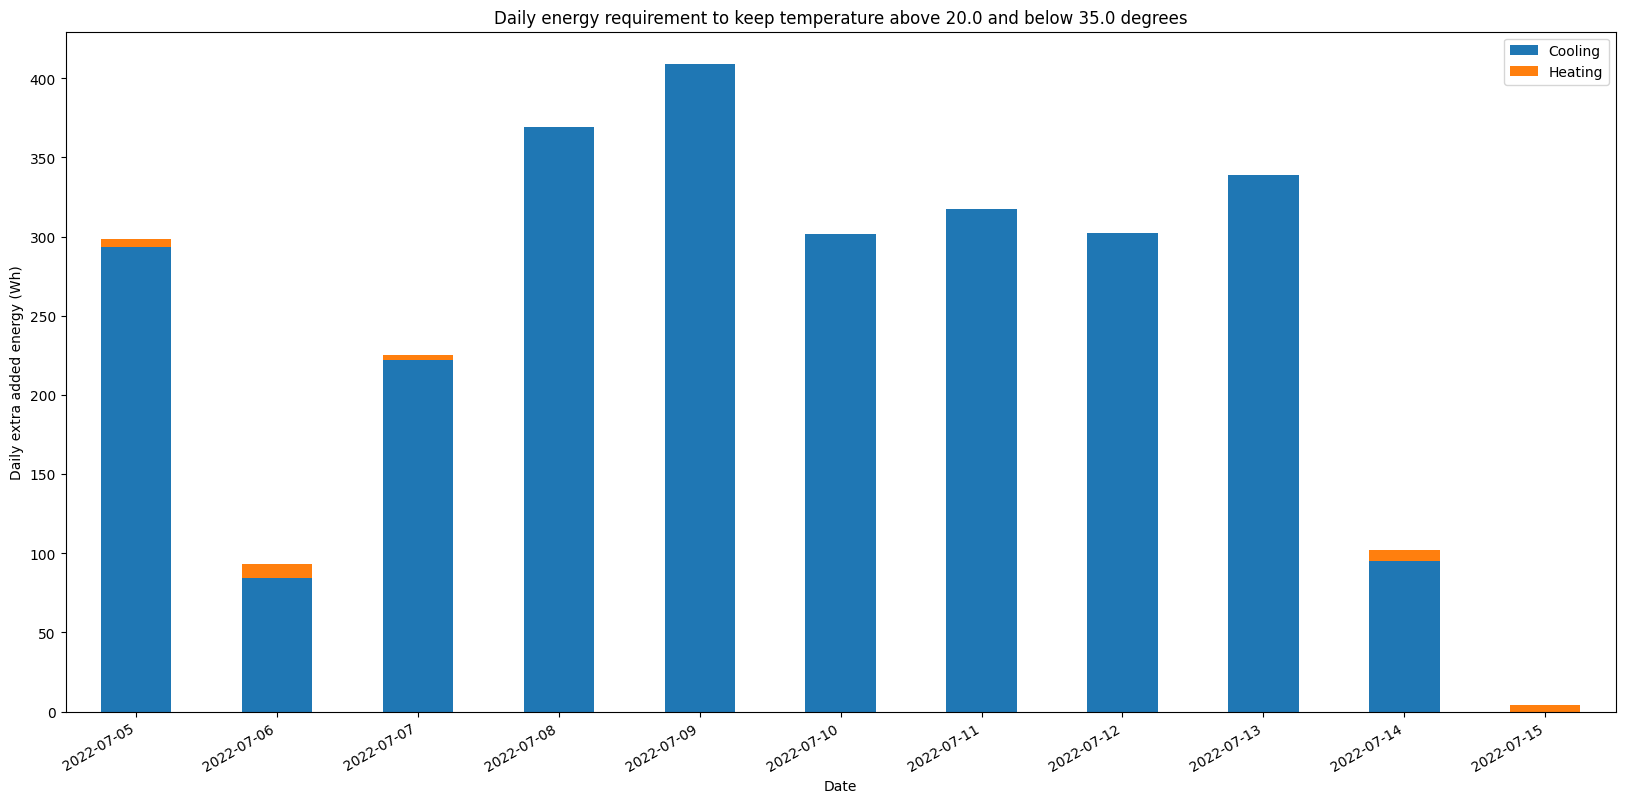

In [66]:
df_cooling = pd.DataFrame({'Date':list(cooling_energy.keys()),'Cooling':list(cooling_energy.values())})
df_heating = pd.DataFrame({'Date':list(heating_energy.keys()),'Heating':list(heating_energy.values())})
df_cooling.set_index('Date',inplace=True)
df_heating.set_index('Date',inplace=True)
df_combined = pd.merge(df_cooling,df_heating,left_index=True,right_index=True,how='outer')
ax = df_combined.plot(kind='bar',stacked=True)
plt.title('Daily energy requirement to keep temperature above '+ str(T_cap_low-273.15)+ ' and below '+ str(T_cap-273.15)+' degrees')
plt.ylabel('Daily extra added energy (Wh)')
plt.gcf().autofmt_xdate()
plt.plot()

#dates = list(cooling_energy.keys())
#dates_heating = list(heating_energy.keys())
#values_cooling = list(cooling_energy.values())
#values_heating = list(heating_energy.values())


#plt.bar(dates,values_cooling)
#plt.bar(dates_heating,values_heating,values_cooling)
#plt.title("Daily amount of extra energy required to keep reactor below "+ str(T_cap-273.15)+' degrees')
#plt.xlabel('Day of the year')
#plt.ylabel('Required cooling energy (Wh)')
#plt.ylim(0,500)
#total_cooling = sum(values_cooling)/1000
#total_heating = sum(values_heating)/1000
df_combined.describe

In [67]:
# Just checking some values, dont pay to much attention to this 
Re_reactor = rho_reactor*flow_speed_reactor*(2*R_reactor)/mu_reactor
Re_air = rho_air*0*2*(R_reactor+glass_thickness)/mu_air 
Pr_air = cp_air*mu_air/k_air
Pr_reactor = cp_reactor*mu_reactor/k_reactor

empty_trial = []
empty_trial.append([2,4])
empty_trial.append([6,9])
#A = np.array(empty_trial)
#A[:,1]
1.7/V_reactor*400*0.29

68370.9762174117

In [68]:
# See if a smaller time step would change the values of the calculated temperatures (spoiler, it did not)
t_span_small = np.arange(t_span[0],t_span[-1],5/60)
#solver_small = integrate.solve_ivp (heat_bal2,(t_span_small[0],t_span_small[-1]) ,y0, args = [0.01],t_eval=t_span_small, method='RK45')
t_vals_small = solver_small.t
y_vals_small = solver_small.y[0]-273.15
for t in t_vals_small:
    months = t//(3600*24*30)
    days = (t-3600*24*30*months)//24*3600
    hours = (t-3600*24*30*months-24*3600*days)//3600
    minutes = (t-3600*24*30*months-24*3600*days-hours*3600)/60
    #dates = time.datetime(2022,months,days,hours,minutes)
plt.plot(t_vals_small,y_vals_small,t_vals,y_vals-273.15)
plt.legend(['6 min','1 hour'])
plt.title('comperison of calculation interval')

NameError: name 'solver_small' is not defined